<a href="https://colab.research.google.com/github/musandur/ML-Projects/blob/main/Image_Segmentation_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>>>>>>**Image Segmentation using U-net: Version1**
*****

We perform a **custom** image segmentation using the U-net CNN architecture. I have created this dataset by simulating some mathematical models. It is thus a synthetic dataset. Hence, I did all the end-to-end preprocessing tasks, including labelling, masks creation, etc.

In [1]:
import tensorflow as tf
import keras
from keras import layers, Model, optimizers
from keras.layers import Add, Input, Conv2D, Conv2DTranspose, MaxPooling2D, Lambda, Dropout, concatenate 
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
#----Authorise and mount my Google drive---#
from google.colab import drive
drive.mount('/content/drive')

#-----Unzip my dataset from GC (Google Colab)----'
#!unzip -uq "/content/drive/MyDrive/dataset.zip" -d "/content/drive/MyDrive/"



Mounted at /content/drive


In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
seed = 33

import os
import numpy as np
import random
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

np.random.seed = seed

>>**Load the data and corresponding masks into respective numpy arrays**

Note that the test data have no masks. That is important because the model we will build will predict their masksfor us. This is indeed the main purpose of image segmentation.

In [4]:
TRAIN_PATH = '/content/drive/MyDrive/dataset/train_dataset/'
TEST_PATH =  '/content/drive/MyDrive/dataset/test_dataset/'

train_imgs = sorted(next(os.walk(TRAIN_PATH + 'images' + '/'))[2], key=lambda x: int(x.split('.')[0]))
label_imgs = sorted(next(os.walk(TRAIN_PATH + 'bmasks' + '/'))[2], key=lambda x: int(x.split('.')[0]))
test_imgs = sorted(next(os.walk(TEST_PATH + 'images' + '/'))[2],  key=lambda x: int(x.split('.')[0]))
print(train_imgs)
print(label_imgs)
print(test_imgs)

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png']
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.pn

In [5]:
X_train = np.zeros((len(train_imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_imgs), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((len(test_imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)


In [6]:
# load and, if necessary, resize the data
n = 0
for train, label in tqdm(zip(train_imgs, label_imgs)):
  # images
  img_path = os.path.join(TRAIN_PATH + 'images/', train)
  img = imread(img_path)[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[n] = img

  # masks
  mask_path = os.path.join(TRAIN_PATH + 'bmasks/', label)
  img_mask = imread(mask_path)[:,:,:1]
  #print(img_mask.shape)
  img_mask = resize(img_mask, (IMG_HEIGHT, IMG_WIDTH),mode='constant', preserve_range=True)
  Y_train[n] = img_mask
  n +=1




83it [01:32,  1.11s/it]


In [7]:
# load test dataset
for i , test in tqdm(enumerate(test_imgs)):
  img_path = os.path.join(TEST_PATH + 'images/', test)
  img = imread(img_path)[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[i] = img


15it [00:08,  1.86it/s]


In [8]:
# Display both the image and its binary mask
def plot_pair(images):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(11, 11))
    ax[0].imshow(images[0])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    
    ax[1].imshow(np.squeeze(images[1]), cmap='gray', alpha=.9)
    plt.axis('off')
    plt.show()

>>>**Display the train dataset and corresponding masks**

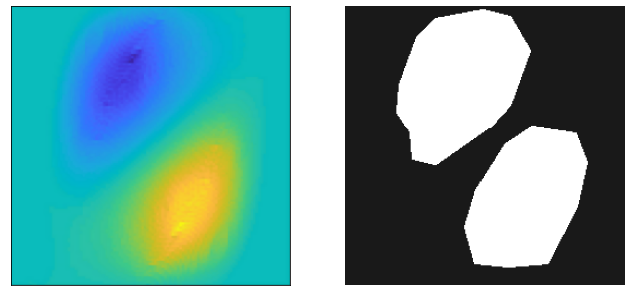

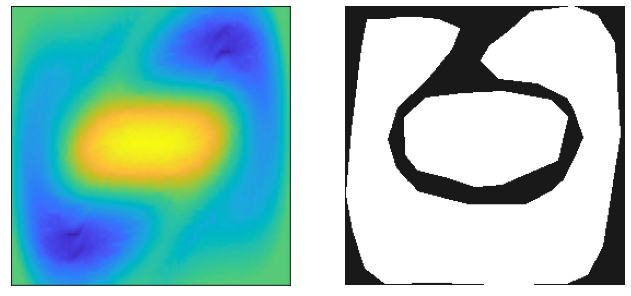

In [9]:
# may want to use plot_pair function
ix = random.randint(0, len(train_imgs)-1)
plot_pair([X_train[ix], Y_train[ix]])

ix = random.randint(0, len(train_imgs)-1)
plot_pair([X_train[ix], Y_train[ix]])

>>>>**Visualize test data**

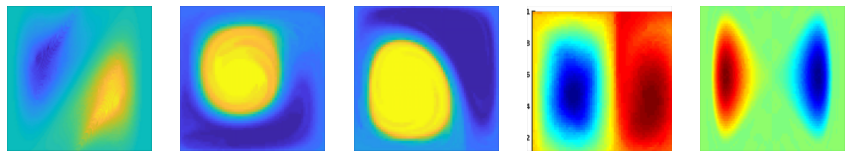

In [10]:
# Display the test dataset
plt.figure(figsize=(15, 15))
for i in range(5):
  plt.subplot(1, 5, i+1)
  ix = random.randint(0, len(test_imgs)-1)
  plt.imshow(X_test[ix])
  plt.axis('off')
plt.show()

>>>>**Define the U-net model and fit the data for training**

In [11]:


inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = Lambda(lambda x: x/255.0)(inputs)

# Contraction path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='Same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs = [inputs], outputs=[outputs])
model.compile(optimizer= tf.keras.optimizers.Adam(), loss= tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

# Modelcheckpoint

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

#callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#            tf.keras.callbacks.TensorBoard(log_dir='logs')]
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs')]


results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=100, callbacks=callbacks)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

**Checking our model's performance by visualizing the train and validation predictions**

1/1 [==============================] - 0s 371ms/step


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


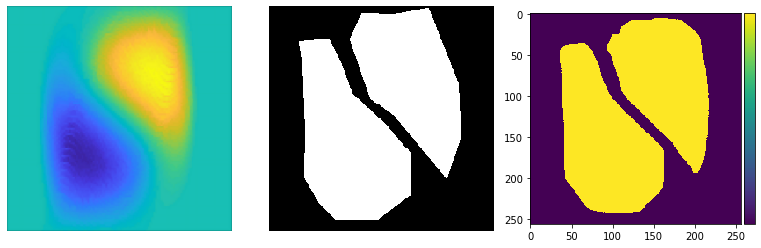

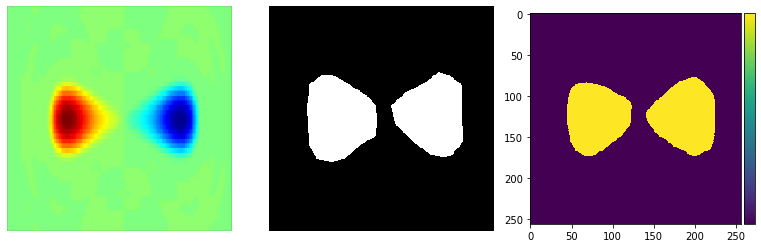

In [12]:
#idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#pred_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (pred_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t)-1)
XX_train = [X_train[ix], np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix])]
plt.figure(figsize=(11, 11))
for i in range(3):
  plt.subplot(1, 3, i+1)
  imshow(XX_train[i])
  plt.axis('off')
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t)-1)
XX_val = [X_train[int(X_train.shape[0]*0.9):][ix], np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]), np.squeeze(preds_val_t[ix])]
plt.figure(figsize=(11, 11))
for i in range(3):
  plt.subplot(1, 3, i+1)
  imshow(XX_val[i])
  plt.axis('off')
plt.show()



>>>>>**Testing the model**

**Making predictions of masks**. That means a given image will be segmented by our model.

In [13]:
preds_test = model.predict(X_test[:int(X_test.shape[0])], verbose=1)

preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 1s 514ms/step


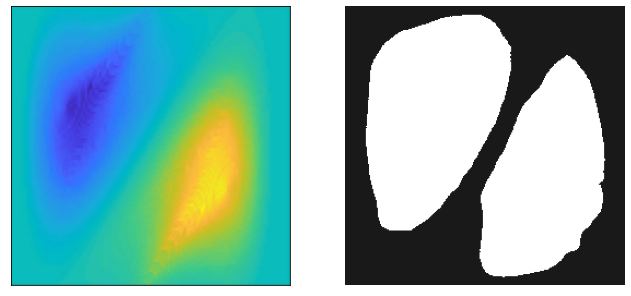

In [14]:
ix = random.randint(0, len(X_test)-1)
k = 0
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


#imshow(X_test[ix])
#plt.show()

#imshow(np.squeeze(preds_test_t[ix]))
#plt.show()

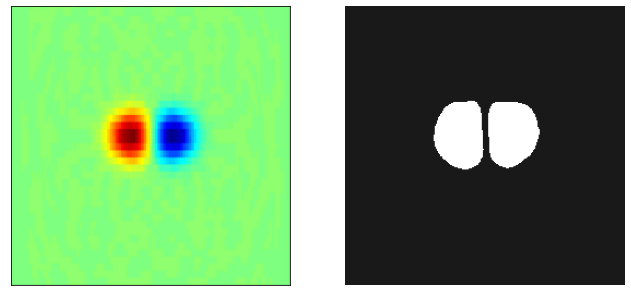

In [15]:
k = 1
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


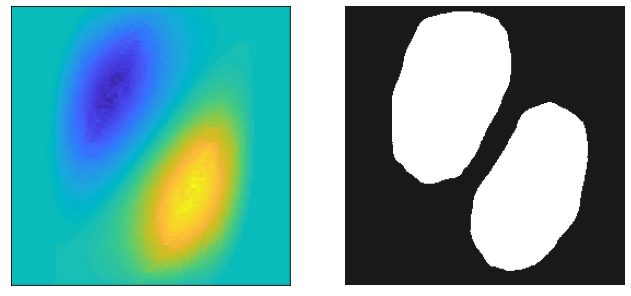

In [16]:
k = 2
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


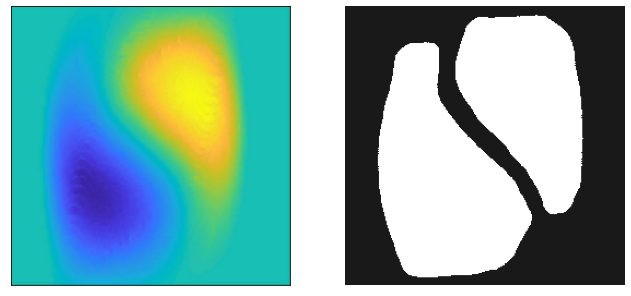

In [17]:
k = 3
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


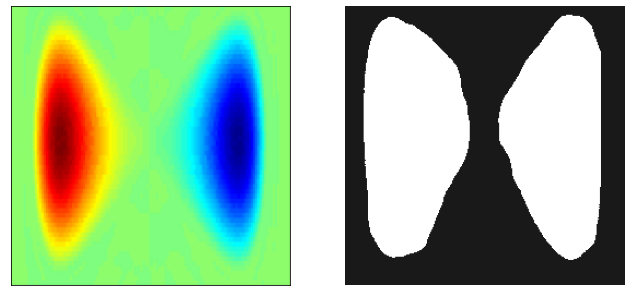

In [18]:
k = 4
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


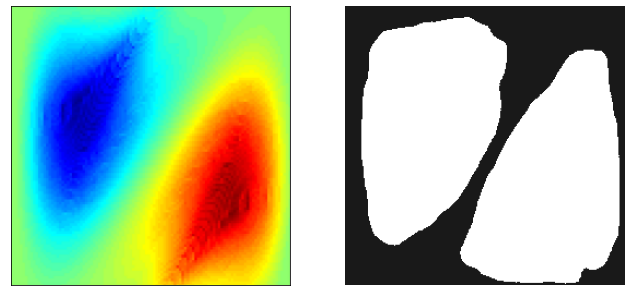

In [19]:
k = 5
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


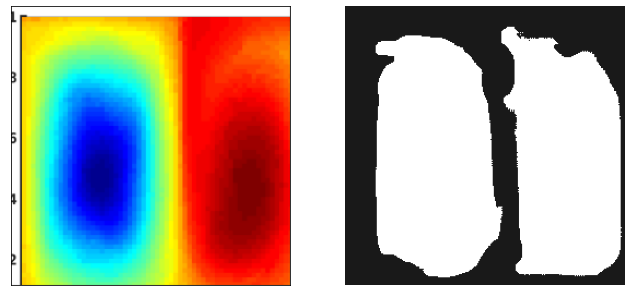

In [20]:
k = 6
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


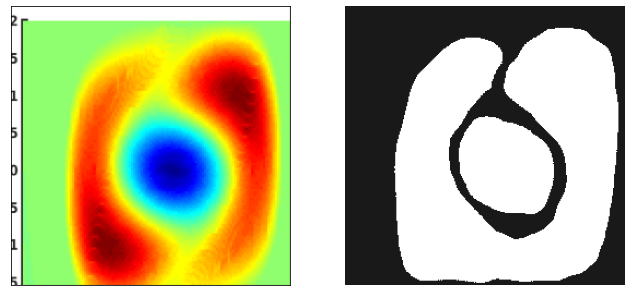

In [21]:
k = 7
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


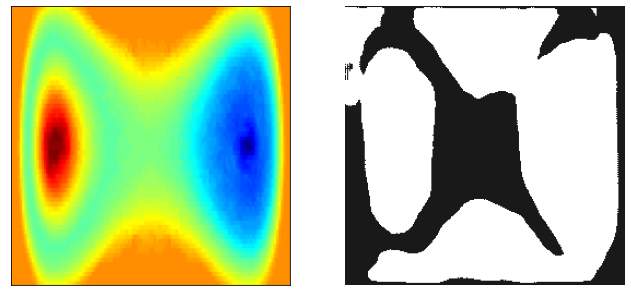

In [22]:
k = 8
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


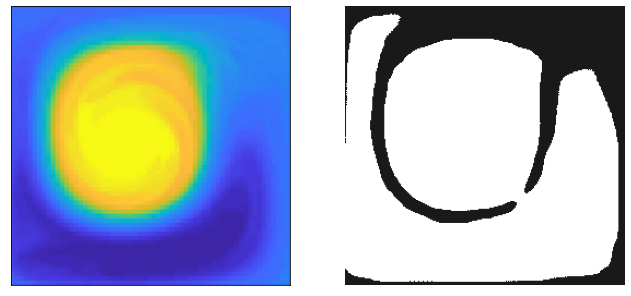

In [23]:
k = 9
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


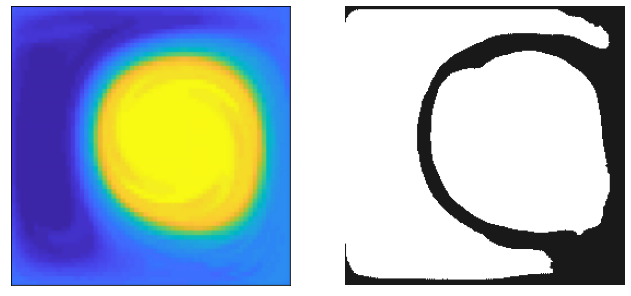

In [24]:
k = 10
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


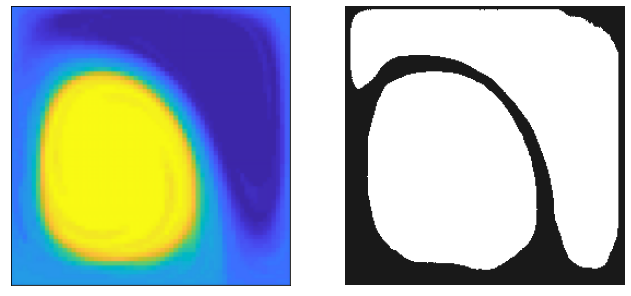

In [25]:
k = 11
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


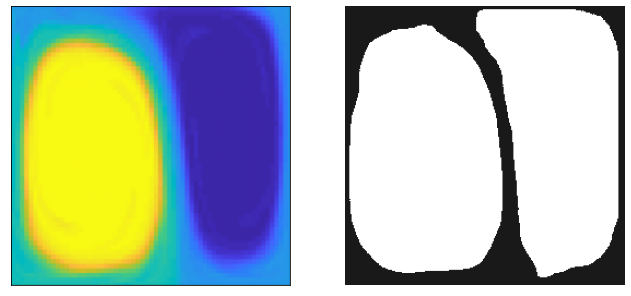

In [26]:
k = 12
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


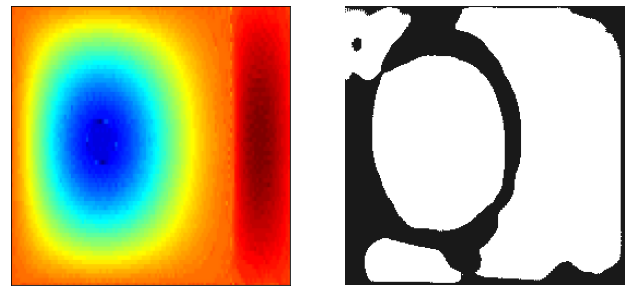

In [27]:
k = 13
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


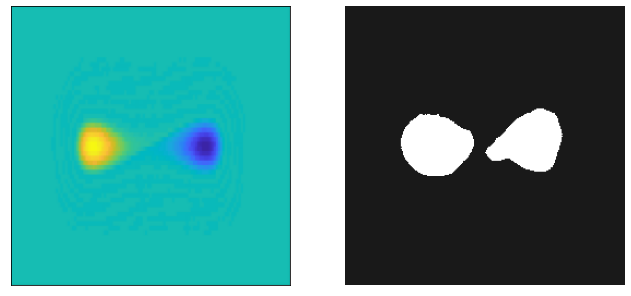

In [28]:
k = 14
plot_pair([X_test[k], np.squeeze(preds_test_t[k])])


We have built an image segmentation model with a fairly good performance on a test dataset. In fact, we have constructed a very small custom dataset. Therefore, we are going to implement a more interesting version of this work, where we will implemente a multi-channel imgae segmetation model. Besides, we will implement an opencv-based data augmentation module in order to improve model accuracy. There, we will also generate data on the fly, as loading all the data at once may cost a lot of memory.